In [ ]:
import enum
import os
import sys
from datetime import date

import matplotlib.pyplot as plt
import pandas as pd

# Add the root dir to the path, so we can load the module.
sys.path.append(os.path.abspath(".."))

from data_analysis.allowances_utils import get_allowances_data
from data_analysis.eurostat_crf_utils import get_eurostat_crf_data_for_code


This notebook prepares data and charts for the infographic of top GHG emitters in Czechia.

The workflow is as follows:
1. Define parametrs and assign facility names and types to permit IDs.
2. Load the ETS verified emissions dataset.
3. Augment the ETS dataset with facility details.
4. Create emissions pivot table.
5. Add facility names and total emissions.
6. Compare with previous year.
7. Check top 10 facilities below the line (places 31–40).
8. Generate helper bart chart and accompanying text.


## 1. Define the structure of facilities


In [ ]:
DATASET_PATH = "../data/EUA/verified_emissions_2023_en.xlsx"
FACILITY_DETAILS_PATH = "../data/EUA/top-emitters-cz.csv"
# Year we want to visualize.
YEAR = 2023
# Year we want to compare with (need not be the previous year).
COMPARISON_YEAR = 2021
# Amount of emissions per one square.
SQUARE_VALUE_MT = 0.25

class SquareTypes(enum.Enum):
    HEAT_POWER = "HeatPower"
    STEEL = "IronSteel"
    REFINING = "Refining"
    LIME_CEMENT = "LimeCement"
    OTHER = "Other"

activites_map = {
    2: SquareTypes.REFINING.value,
    20: SquareTypes.HEAT_POWER.value,
    21: SquareTypes.REFINING.value,
    24: SquareTypes.STEEL.value,
    25: SquareTypes.STEEL.value,
    29: SquareTypes.LIME_CEMENT.value,
    30: SquareTypes.LIME_CEMENT.value,
}

facility_details = pd.read_csv(FACILITY_DETAILS_PATH)

facility_details_long = facility_details.copy()
facility_details_long["permit_id"] = \
    facility_details_long["permit_ids"].str.split("|")
del facility_details_long["permit_ids"]
facility_details_long = facility_details_long.explode("permit_id")


## 2. Load ETS dataset


In [3]:
def fix_allowance_df(df: pd.DataFrame) -> pd.DataFrame:
    return df.rename(
        columns={
            "MAIN_ACTIVITY_TYPE_CODE": "activity_code",
            "value": "MtCO2eq",
        }
    )


In [4]:
allowances_df = fix_allowance_df(
    get_allowances_data(
        YEAR, "CZ", None, DATASET_PATH
    )
)

allowances_df.sort_values(by="MtCO2eq", ascending=False).head()


,MtCO2eq,IDENTIFIER_IN_REG,activity_code
PERMIT_IDENTIFIER,,,
CZ-0204-05,4.094255,"Elektrárna Počerady, a.s.",20
CZ-0209-05,3.570884,ČEZ - Elektrárna Tušimice 2,20
CZ-0207-05,3.025634,ČEZ - Elektrárna Prunéřov 2,20
CZ-0200-05,2.893905,Elektrárna Chvaletice a.s.,20
CZ-0201-05,2.823304,ČEZ - Elektrárna Ledvice,20


In [5]:
total_ets_emissions_mtco2eq = allowances_df.MtCO2eq.sum()
print(f"ETS emissions total: {total_ets_emissions_mtco2eq:.1f} Mt CO₂eq")


ETS emissions total: 46.7 Mt CO₂eq


## 3. Augment with facility details


In [16]:
facility_activity_df = (
    allowances_df.copy()
    .merge(
        facility_details_long[["facility_id", "permit_id"]],
        how="left",
        left_on="PERMIT_IDENTIFIER",
        right_on="permit_id"
    )
)

facility_activity_df["activity"] = (
    facility_activity_df["activity_code"]
    .map(activites_map)
    .fillna(SquareTypes.OTHER.value)
)

known_facilities = (
    facility_activity_df[["facility_id", "activity", "MtCO2eq"]]
    .groupby(["facility_id", "activity"])
    .sum()
    .reset_index(level=1)
    .merge(
        facility_details[["facility_id", "facility_name", "lat", "lon"]],
        how="left",
        left_index=True,
        right_on="facility_id"
    )
    .set_index(["facility_id", "facility_name"])
)

top_30_wide = known_facilities.pivot(columns="activity", values="MtCO2eq").fillna(0)
top_30_wide["Total"] = (
    top_30_wide["HeatPower"] +
    top_30_wide["IronSteel"] +
    top_30_wide["LimeCement"] +
    top_30_wide["Refining"]
)
top_30_wide = top_30_wide.sort_values(by="Total", ascending=False).head(30)
top_30_wide


,activity,HeatPower,IronSteel,LimeCement,Refining,Total
facility_id,facility_name,,,,,
1,Elektrárna Počerady,4.690547,0.000000,0.000000,0.000000,4.690547
3,Třinecké železárny a Energetika Třinec,1.418581,2.536457,0.000000,0.000000,3.955038
7,Elektrárna Tušimice,3.570884,0.000000,0.000000,0.000000,3.570884
5,Rafinerie Litvínov,3.039127,0.000000,0.000000,0.404764,3.443891
6,Elektrárna Prunéřov,3.025634,0.000000,0.000000,0.000000,3.025634
8,Elektrárna Chvaletice,2.893905,0.000000,0.000000,0.000000,2.893905
4,Elektrárna Ledvice,2.823304,0.000000,0.000000,0.000000,2.823304
2,Liberty Ostrava a TAMEH Czech,2.392206,0.041000,0.000000,0.000000,2.433206
9,Elektrárna Mělník,1.921436,0.000000,0.000000,0.000000,1.921436


In [7]:
# A quick check that no large emitters were left behind.
facility_activity_df[facility_activity_df.facility_id.isna()] \
    .sort_values(by="MtCO2eq", ascending=False).head()


,MtCO2eq,IDENTIFIER_IN_REG,activity_code,facility_id,permit_id,activity
40,0.237142,"Smartwings, a.s.",10,NaN,NaN,Other
42,0.206465,Synthesia - odštěpný závod SYNTHESIA,20,NaN,NaN,HeatPower
44,0.190399,Lovochemie - Uhelná kotelna,20,NaN,NaN,HeatPower
45,0.186415,AGC Flat Glass - závod Řetenice,31,NaN,NaN,Other
46,0.119417,Teplárny Brno - Provoz Červený Mlýn,20,NaN,NaN,HeatPower


Pivot back to long format for export and further processing.


In [ ]:
top_30_long = known_facilities.loc[top_30_wide.index]
top_30_long.to_csv("../outputs/top-30-emitters-cz.csv")


## 4. Create emissions pivot table with columns per square type


In [30]:
def create_pivot_df_grouped_by_facility_id(df: pd.DataFrame) -> pd.DataFrame:
    """
    Group by `facility_id` and `activity` and sum `MtCO2eq` emissions by type, then pivot by
    `facility_id`, turning individual square types to columns.
    """
    df = df.groupby(["facility_id", "activity"]).sum().round(2)
    df = pd.pivot_table(
        df, index=["facility_id"], columns="activity", values="MtCO2eq", fill_value=0)
    df.astype(int)
    return df


In [32]:
pivot_df = create_pivot_df_grouped_by_facility_id(top_30_long)
pivot_df.head()


activity,HeatPower,IronSteel,LimeCement,Refining
facility_id,,,,
1,4.69,0.00,0.0,0.0
2,2.39,0.04,0.0,0.0
3,1.42,2.54,0.0,0.0
4,2.82,0.00,0.0,0.0
5,3.04,0.00,0.0,0.4


## 5. Add back facility name and total emissions, add square counts


In [ ]:
def create_df_facility_emision_value(df):
    """Group by facility_id and name_id, sum  MtCO2eq emisions by facility"""
    return df.groupby(["facility_id", "facility_name"]).sum().round(3)

def add_squares_count(df) -> None:
    """Computes and adds squares for the total emissions and per emissions type as new columns"""
    df["sq_TOTAL"] = (df["MtCO2eq"] / SQUARE_VALUE_MT).round().astype(int)
    for square_type in SquareTypes:
        if square_type.value not in df.columns:
            continue
        df[f"sq_{square_type.value}"] = (df[square_type.value] / SQUARE_VALUE_MT).round().astype(int)


In [43]:
# Group by facility_id, sum emmisions, compute total squares.
facility_emission_value_df = create_df_facility_emision_value(top_30_long)
df_output = facility_emission_value_df.join(pivot_df)
# Add squares count (total and per each type).
add_squares_count(df_output)
# Make a copy of df and replace zeros in the copy for better legibility
df_output_to_view = df_output.copy()
df_output_to_view.replace(0, "-", inplace=True)
df_output_to_view.sort_values(by="MtCO2eq", ascending=False)


,,activity,MtCO2eq,lat,lon,HeatPower,IronSteel,LimeCement,Refining,sq_TOTAL,sq_HeatPower,sq_IronSteel,sq_Refining,sq_LimeCement
facility_id,facility_name,,,,,,,,,,,,,
1,Elektrárna Počerady,HeatPower,4.69,50.43,13.68,4.69,-,-,-,19,19,-,-,-
3,Třinecké železárny a Energetika Třinec,HeatPowerIronSteel,3.96,99.38,37.30,1.42,2.54,-,-,16,6,10,-,-
7,Elektrárna Tušimice,HeatPower,3.57,50.38,13.34,3.57,-,-,-,14,14,-,-,-
5,Rafinerie Litvínov,HeatPowerRefining,3.44,101.12,27.20,3.04,-,-,0.4,14,12,-,2,-
6,Elektrárna Prunéřov,HeatPower,3.03,50.42,13.26,3.03,-,-,-,12,12,-,-,-
8,Elektrárna Chvaletice,HeatPower,2.89,50.03,14.34,2.89,-,-,-,12,12,-,-,-
4,Elektrárna Ledvice,HeatPower,2.82,50.58,13.78,2.82,-,-,-,11,11,-,-,-
2,Liberty Ostrava a TAMEH Czech,HeatPowerIronSteel,2.43,99.60,36.62,2.39,0.04,-,-,10,10,-,-,-
9,Elektrárna Mělník,HeatPower,1.92,50.41,14.42,1.92,-,-,-,8,8,-,-,-


## 6. Check top 10 allowances which did not make it to the "top 30" facilities.


In [44]:
# Join all permit ids from the top 30 definition into one list.
permit_ids = []
for facility in definition:
    permit_ids += list(facility["permit_id"].keys())

# Drop allowances in top 30.
below_thirty_df = allowances_df[~allowances_df.index.isin(permit_ids)].copy()

# Group , compute squares, remove decimals from "squares"
below_thirty_df["squares"] = (below_thirty_df["MtCO2eq"] / SQUARE_VALUE_MT).round().astype(int)

below_thirty_df.head(10)


NameError: name 'definition' is not defined

## 7. Create a df for the previous year situation to find out the changes


In [68]:
# Repeat the same for the comparison data frame.

# 1. Get the data
compare_allowances_df = fix_allowance_df(
    get_allowances_data(
        COMPARISON_YEAR, "CZ", None, DATASET_PATH
    )
)
# 2. Add facility details
add_facility_details(compare_allowances_df)
# 3. Create emissions pivot table
compare_pivot_df = create_pivot_df_grouped_by_facility_id(compare_allowances_df)
# 4. Add back facility name and total emissions, add square counts
compare_facility_emission_value_df = create_df_facility_emision_value(compare_allowances_df)
compare_df_output = compare_facility_emission_value_df.join(compare_pivot_df)
add_squares_count(compare_df_output)

compare_df_output.head()


,,MtCO2eq,HeatPower,LimeCem,Refin,Steel,sq_TOTAL,sq_HeatPower,sq_Steel,sq_Refin,sq_LimeCem
facility_id,facility_name,,,,,,,,,,
1.0,"Elektrárna Počerady, a.s.",5.39,5.39,0.0,0.00,0.00,22,22,0,0,0
2.0,Liberty Ostrava a TAMEH Czech,5.18,5.12,0.0,0.00,0.05,21,20,0,0,0
3.0,Třinecké železárny a Energetika Třinec,4.04,1.51,0.0,0.00,2.53,16,6,10,0,0
4.0,Elektrárna Ledvice,3.78,3.78,0.0,0.00,0.00,15,15,0,0,0
5.0,Rafinerie Litvínov,3.71,0.00,0.0,3.71,0.00,15,0,0,15,0


## 8. Compute table to see the changes in comparison with the chosen year


In [ ]:
diff_df = df_output.subtract(compare_df_output)

# Filter out items with no difference
zero_condition = diff_df["sq_TOTAL"] == 0.0
for square_type in SquareTypes:
    zero_condition &= diff_df[f"sq_{square_type.value}"] == 0.0

# Make a copy of df and replace zeros in the copy for better legibility
diff_df_to_view = diff_df[~zero_condition].copy()
diff_df_to_view.replace(0, "-", inplace=True)
diff_df_to_view


,,MtCO2eq,HeatPower,LimeCem,Refin,Steel,sq_TOTAL,sq_HeatPower,sq_Steel,sq_Refin,sq_LimeCem
facility_id,facility_name,,,,,,,,,,
1,"Elektrárna Počerady, a.s.",0.49,0.49,-,-,-,2,2,-,-,-
2,Liberty Ostrava a TAMEH Czech,-0.97,-0.96,-,-,-,-4,-3,-,-,-
4,Elektrárna Ledvice,-0.73,-0.73,-,-,-,-3,-3,-,-,-
8,Elektrárna Chvaletice,1.16,1.16,-,-,-,4,4,-,-,-
9,Elektrárna Mělník,-0.04,-0.04,-,-,-,-1,-1,-,-,-
10,Teplárna Vřesová,-0.44,-0.44,-,-,-,-2,-2,-,-,-
11,Teplárna Kladno,0.15,0.15,-,-,-,1,1,-,-,-
12,Elektrárna Opatovice,-0.22,-0.22,-,-,-,-1,-1,-,-,-
13,Elektrárna Dětmarovice,-0.10,-0.1,-,-,-,-1,-1,-,-,-


## 9. Charts and texts


In [ ]:
def draw_barh_charts(df):
    color = ["dimgrey", "silver"]
    df_charts.plot.barh(stacked=True, color=color, legend=False)

    # Upper chart
    plt.text(part_2 - .62, 0.91, f"{100 * part_1:.0f} %", size=30, color="silver")
    plt.text(0, 1.3, f"Podíl emisních povolenek na celkových ročních emisí ČR v roce {YEAR}.", size=15)

    # lower chart
    plt.text(part_1 - .33, -0.075,f"{100 * part_2:.0f} %", size=30, color="silver");
    plt.text(0, 0.3, f"Emitenti zobrazení v mapě odpovídají za {100 * part_2:.0f} % emisí z těchto povolenek.", size=15)

    # Both charts
    plt.axis("off")


In [ ]:
# Fetch total emissions data
# TODO: Use the new function.
df_emis = get_eurostat_crf_data_for_code("TOTX4_MEMONIA", YEAR)

# Total CR emissions for chosen year, MtCO2eq.
cr_total = df_emis.loc["CZ", "value"]
# Total emissions covered by allowances for chosen year, MtCO2eq.
cr_allow = total_ets_emissions_mtco2eq
# Total emissions displayed in map for chosen year, MtCO2eq.
cr_emit_in_map = top_30_wide["Total"].sum()

# Allowances in % relative to CR.
part_1 = cr_allow / cr_total
# Emitters in map in % relative to allowances emissions.
part_2 = cr_emit_in_map / cr_allow
# Emitters in map in % relative to CR.
part_3 = cr_emit_in_map / cr_total


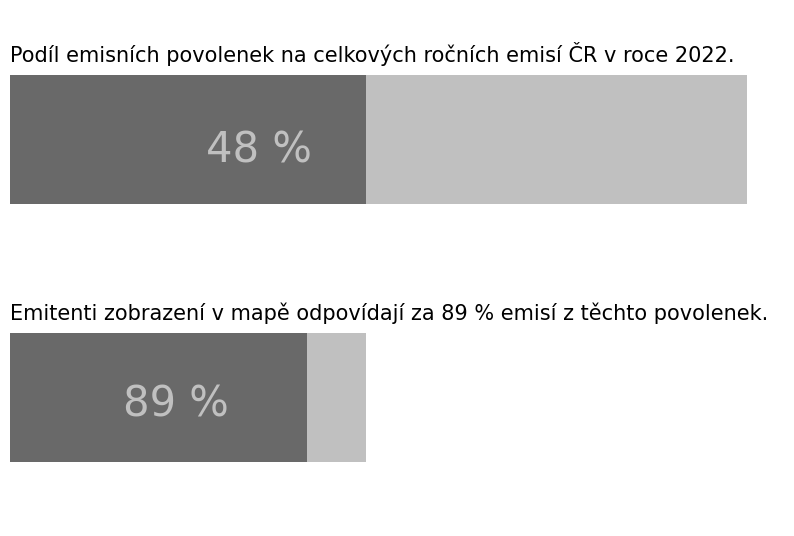

In [ ]:
# Create df as a source for the charts.
data_charts = {
    "allowances": [part_2 - part_1, part_1],
    "other": [part_1 - (part_2 - part_1), 100 - part_1]
}
df_charts = pd.DataFrame(data_charts, index=["CR_2", "CR_rel"])

# Draw charts
draw_barh_charts(df_charts)


In [ ]:
timestamp = date.today().strftime("%Y-%m-%d")

accompanying_text = f'''---
layout:     infographic
title:      "Největší emitenti v ČR v roce {YEAR}"
slug:       "nejvetsi-emitenti-cr"
redirect_from: "/nejvetsi-emitenti-cr"
published:  2021-01-20
weight:     98
tags-scopes: [ cr ]
tags-topics: [ emise ]
caption:    "Téměř polovinu roční produkce skleníkových plynů vypustí několik desítek producentů – elektráren, železáren, cementáren a rafinerií. Většina z nich se nachází v Ústeckém nebo Moravskoslezském kraji. Data jsou k roku {YEAR}."
dataset:    "emise-cr"
autogenerated: "WARNING! This text got autogenerated in faktaoklimatu/data-analysis on {timestamp}. Do not change here, fix it in the source notebook."
---

{{% include preview-box.html
    title="Emise skleníkových plynů v ČR podle sektorů"
    text="Velké podniky v Česku vypouštějí jen asi polovinu emisí skleníkových plynů. Celkový přehled o emisích v Česku nabízí jejich rozdělení podle sektorů."
    slug="emise-cr"
%}}

## Co vidíme v mapě?

* Mapa zobrazuje 30 největších zdrojů emisí skleníkových plynů v České republice – elektrárny a teplárny, ocelárny, cementárny a rafinerie. Zobrazení emitenti představují {part_2:.0f} % emisí pokrytých emisními povolenkami ze systému <glossary id="euets">EU ETS</glossary> pro Českou republiku a celkově {part_3:.0f} % ročních emisí skleníkových plynů České republiky.
* U každého zdroje je znázorněno množství emisí, jeden čtvereček odpovídá 250 000 t <glossary id="co2eq">CO<sub>2</sub>eq</glossary>. Barvy odlišují jednotlivá zařízení podle typu hlavní aktivity: elektrárny a teplárny, vápenky a cementárny, rafinérie, železárny a ocelárny. V oblasti Západních Čech je nakumulována většina zařízení určených k výrobě elektřiny a tepla, zatímco v Moravskoslezském kraji jsou hlavními emitenty podniky určené k výrobě železa a oceli. Významným zdrojem emisí CO<sub>2</sub> jsou také cementárny, jejichž celkový příspěvek v roce {YEAR} činil {czech_float(df_output['LC'].sum().round(1))} Mt CO<sub>2</sub>eq.
* Pro přehlednost jsme u některých zdrojů sloučili více různých emitentů registrovaných v systému ETS do jednoho zobrazeného celku. Např. _Plzeňská teplárenská_ má zvlášť registrované dvě velké teplárny v různých částech města nebo mnohé elektrárny mají zvlášť registrované svoje jednotlivé bloky. Dále jsme přiřadili k hutním podnikům jejich teplárenské složky, protože jsou nutnou součástí jejich provozu (to je jisté zjednodušení, protože tyto teplárenské podniky část vyrobeného tepla či páry dodávají i externím zákazníkům).
* Prakticky všechny zobrazené zdroje emisí produkují pouze CO<sub>2</sub>, jen rafinerie mohou vedle CO<sub>2</sub> vytvářet další skleníkové plyny. V rámci systému obchodování s emisními povolenkami EU ETS i v naší grafice jsou jiné skleníkové plyny než oxid uhličitý převedeny na ekvivalentní množství CO<sub>2</sub>, označované <glossary id="co2eq">CO<sub>2</sub>eq</glossary>.
* Nejvíce ze zobrazených zařízení vlastní _ČEZ_, další jsou ve vlastnictví _Sev.en Energy_, _Skupiny TAURON_ a _LIBERTY Steel Group_.

## Další poznámky

* Evropský ETS byl spuštěn v roce 2005 jako první mezinárodní systém pro obchodování s emisními povolenkami a pokrývá přibližně 40 % emisí skleníkových plynů v EU, především v sektorech energetiky, těžkého průmyslu a letectví. Data z EU ETS poskytují souhrnné údaje o emisích a povolenkách podle zemí, odvětví a roku a pocházejí hlavně z protokolu transakcí EU EUTL. Data jsou poskytována Evropskou komisí a spravována Evropskou agenturou pro životní prostředí.
* Pro širší kontext si můžete prohlédnout uhelné elektrárny světa na [interaktivní mapě](https://www.carbonbrief.org/mapped-worlds-coal-power-plants), která mj. umožňuje i posun v čase. Odpoví na otázky typu kdy nastal uhelný boom v Číně nebo jak výkonné máme elektrárny třeba oproti Polsku.
'''

print(accompanying_text)